## Business Case


which features to cross
only upgrade bikes when we really need to
from the features the algortihm  should estimate how long the rides should take
since it is more important to classify them


this will be used to put more bikes in that area to earn more money since the time takes longer making more money and do more maintaince on that area as awell
since the bikes are a capital good they can always be taken away meaning it is better to classify the instance as high duration
prioritizing percision would help improve confidence and be sure that place is properly maintained the ones that are not maintained can be manually viewed
this is less expensive than focussing on recall because that would be more instances of spending more on underutilized ones.
In general people want ot err on the sid of spending less money and would rather allow a few complaints to fix it.



## Which Features to Cross

cross_columns = [['month','week','day'],['events','hour']]

Crossing month, day and week would help memorize if a bike is more likely to be used on certain specific dates.
Crossing events and hours would help get the effect of knowing that under problematic conditions(storm at 12 am) the bike would be used for longer periods.

## Performance Metric

We want a high precision for classifying bikes as new. That way we can be sure that the bikes that are worked on are upgraded. The business in this case would want to do bare minimum and ensure their funding is going toward only the worst bikes.

## Method for training and testing

i would use k fold cross validation to identify which algorithm is better. The classes are already fairly biased and this is a binary classification. I will shuffle to prevent any one  fold from having too much of the same time periodself.
this would be an realistic way of testing because the dataset division of kfold would mimic the fact that all dataset of bikes used for training will have equal amounts of highly used bikes.

## Preprocessing

In [1]:
#https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

filename = "chicago-divvy-bicycle-sharing-data/data.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 100000 #desired sample size
skip = sorted(rd.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
bike_rides = pd.read_csv(filename, skiprows=skip)
print(bike_rides.shape)
#remove trip duation and make as the y variable categorical label, coordingates, usetypes were all subscriber, times were already give, station name already has id,
bike_rides = bike_rides.drop(columns=['trip_id','year','latitude_end', 'longitude_end', 'latitude_start', 'longitude_start', 'usertype', 'starttime','stoptime','from_station_name','to_station_name'])
bike_rides.head()

bike_rides.tripduration.max()
labels = ["{0} - {1}".format(i, i + 4) for i in range(0, 60, 5)]


bike_rides['tripduration'].max()


bike_rides['gender'].value_counts()
bike_rides['to_station_id'].value_counts()
bike_rides['events'].value_counts()


sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.distplot(a=bike_rides["tripduration"])
plt.show()

list(bike_rides.columns)
bike_rides.loc[bike_rides['tripduration'] < 10,'group_duration'] = "LOW"
bike_rides.loc[bike_rides['tripduration'] > 10,'group_duration'] = "HIGH"
bike_rides.head()

(100000, 23)


<Figure size 640x480 with 1 Axes>

,month,week,day,hour,gender,tripduration,temperature,events,from_station_id,dpcapacity_start,to_station_id,dpcapacity_end,group_duration
0,6,27,0,21,Male,6.400000,70.0,tstorms,291,19.0,337,19.0,LOW
1,6,27,0,21,Male,10.300000,70.0,tstorms,106,27.0,174,23.0,HIGH
2,6,27,0,20,Female,20.616667,70.0,rain or snow,126,15.0,296,15.0,HIGH
3,6,27,0,19,Male,9.283333,73.0,tstorms,175,19.0,19,15.0,LOW
4,6,27,0,18,Male,7.783333,82.0,tstorms,276,11.0,158,15.0,LOW


In [2]:
bike_rides["events"].value_counts()

cloudy          88489
clear            5333
rain or snow     4548
not clear         948
tstorms           679
unknown             3
Name: events, dtype: int64

### Data Description
- *dp* is the total number of docs at each station
- *temperature* is in farenheight
- *tripduration* is in minutes
- **target:** group duration can be low (<10min) high(>10min)
- *events* can be clouds, clear, rain/snow, not clear, tstorm


### Encoding data and standardizing numeric data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# bike_rides[categorical_headers] = bike_rides[categorical_headers].astype(str)
categorical_headers = ['month','week','day','hour','gender','events']
bike_rides[categorical_headers] = bike_rides[categorical_headers].astype(str)

df_train, df_test = train_test_split(bike_rides, test_size=0.2)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.dropna(inplace=True)
df_test.reset_index()
print(df_test.group_duration.value_counts())

#,'from_station_id','to_station_id'
encoders = dict()



for col in categorical_headers + ['group_duration'] :
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()

    if col=="group_duration":
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
        df_test[col] = tmp.transform(df_test[col])
    else:
        # integer encoded variables
        encoders[col] = LabelEncoder()
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
        df_test[col+'_int'] = encoders[col].transform(df_test[col])


# scale the numeric, continuous variables
numeric_headers = ['temperature','dpcapacity_start','dpcapacity_end']

for col in numeric_headers :
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)

    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))

df_test.head()





from sklearn.preprocessing import OneHotEncoder
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
#   this is just to get an example running in Keras (don't ever do this)
feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

y_train = df_train['group_duration'].values.astype(np.int)
y_test = df_test['group_duration'].values.astype(np.int)


ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# and save off the numeric features
X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values

print(df_test.group_duration.value_counts())
print(feature_columns)
df_test[feature_columns].head()

LOW     10412
HIGH     9564
Name: group_duration, dtype: int64
1    10412
0     9564
Name: group_duration, dtype: int64
['month_int', 'week_int', 'day_int', 'hour_int', 'gender_int', 'events_int', 'temperature', 'dpcapacity_start', 'dpcapacity_end']


,month_int,week_int,day_int,hour_int,gender_int,events_int,temperature,dpcapacity_start,dpcapacity_end
35499,3,45,1,9,1,1,-1.105970,1.271880,-0.826570
44672,6,7,1,9,0,1,-0.697330,-0.831427,-0.826570
67706,1,35,1,22,1,1,-0.055180,-0.831427,1.276161
47959,7,9,6,2,1,1,-0.055180,3.375187,-0.300887
42704,4,49,0,21,1,3,-1.929089,1.271880,0.750479


## Visualize Performance of the Network

In [4]:
from sklearn import metrics as mt
import keras
from keras import regularizers
keras.__version__

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Concatenate
from keras.layers import concatenate
from keras.models import Model

import functools
from keras import backend as K
import tensorflow as tf
    
#from stackoverflow example
def as_keras_metric(method):

    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
precision = as_keras_metric(tf.metrics.precision)


from sklearn.preprocessing import OneHotEncoder

cross_columns = [['month','week','day'],['events','hour']]


#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()

    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )

    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)

# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )

    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)

# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=100,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep1')(deep_branch)
deep_branch = Dropout(0.5)(deep_branch)
deep_branch = Dense(units=90,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep2')(deep_branch)
deep_branch = Dropout(0.5)(deep_branch)
deep_branch = Dense(units=80,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep3')(deep_branch)
deep_branch = Dropout(0.5)(deep_branch)
deep_branch = Dense(units=70,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep4')(deep_branch)
deep_branch = Dropout(0.5)(deep_branch)


final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

Using TensorFlow backend.


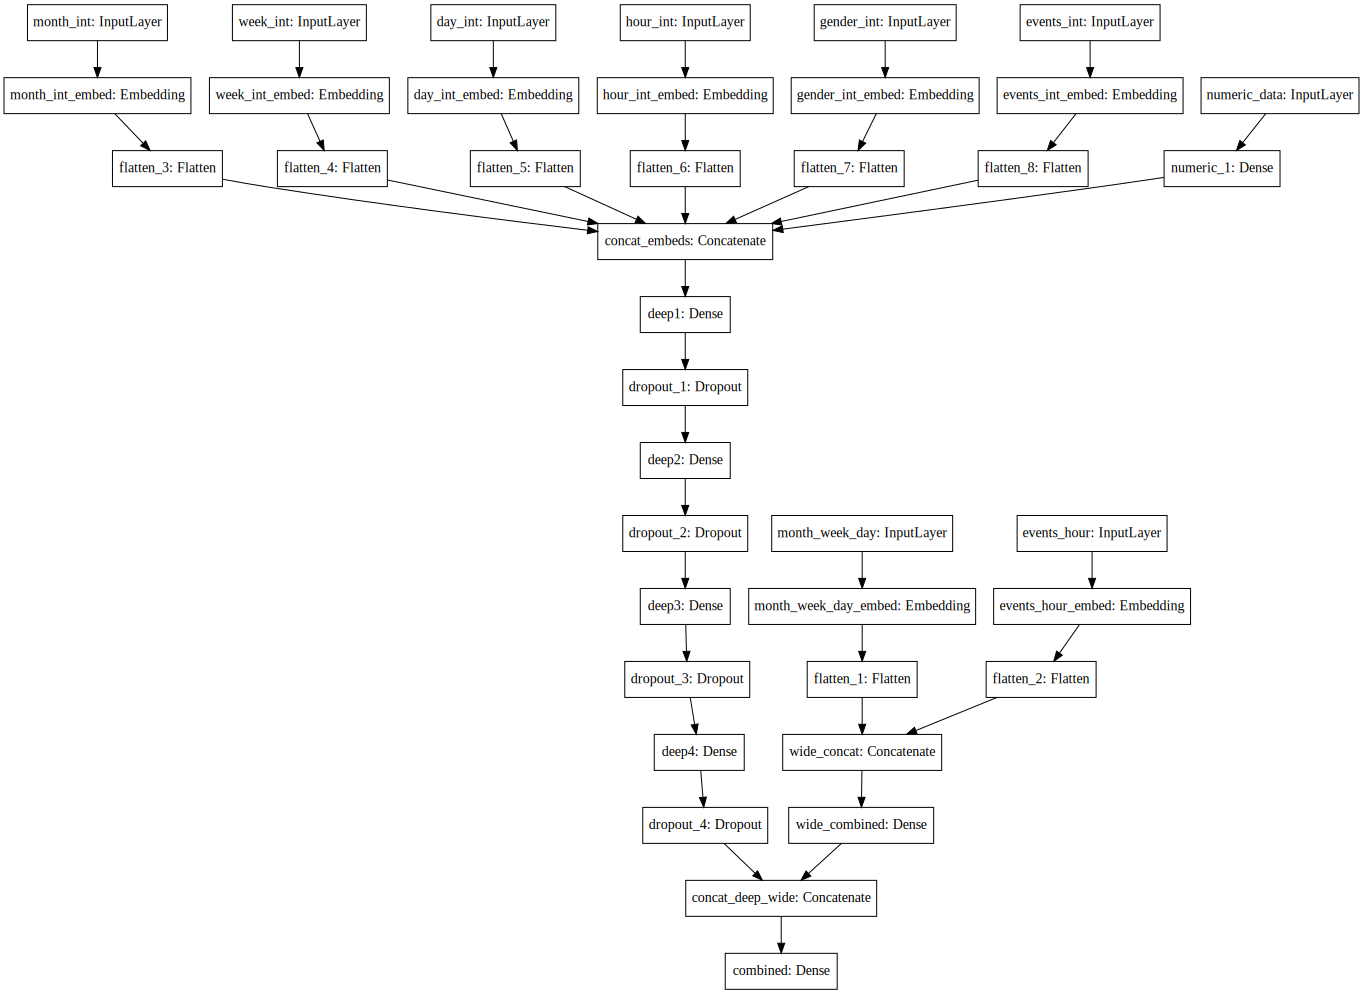

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [6]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
precision = as_keras_metric(tf.metrics.precision)

Train on 79936 samples, validate on 19976 samples
Epoch 1/10
79936/79936 [==============================] - 7s 82us/step - loss: 0.7258 - precision: 0.5204 - val_loss: 0.6919 - val_precision: 0.5204
Epoch 2/10
79936/79936 [==============================] - 6s 71us/step - loss: 0.6908 - precision: 0.5208 - val_loss: 0.6903 - val_precision: 0.5205
Epoch 3/10
79936/79936 [==============================] - 6s 74us/step - loss: 0.6884 - precision: 0.5204 - val_loss: 0.6888 - val_precision: 0.5206
Epoch 4/10
79936/79936 [==============================] - 6s 75us/step - loss: 0.6865 - precision: 0.5207 - val_loss: 0.6879 - val_precision: 0.5206
Epoch 5/10
79936/79936 [==============================] - 7s 86us/step - loss: 0.6853 - precision: 0.5206 - val_loss: 0.6873 - val_precision: 0.5206
Epoch 6/10
79936/79936 [==============================] - 7s 84us/step - loss: 0.6846 - precision: 0.5205 - val_loss: 0.6870 - val_precision: 0.5206
Epoch 7/10
79936/79936 [==============================] 

Text(0.5,0,'epochs')

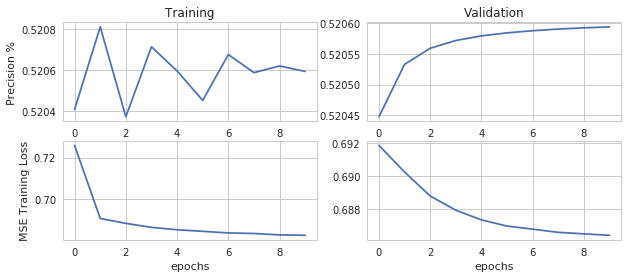

In [7]:
model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=[precision])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit(X_ints_train+ [X_train_num],
                    y_train,
                    epochs=10,
                    batch_size=32,
                    verbose=1,
                    validation_data = (X_ints_test + [X_test_num], y_test))

yhat = np.round(model.predict(X_ints_test + [X_test_num]))
print(mt.confusion_matrix(y_test,yhat), mt.precision_score(y_test,yhat))

from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

# Altering number of layers

## 5 layers

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, make_scorer
from sklearn.model_selection import KFold


new_df = pd.concat([df_train,df_test], axis=0)

new_df.dropna(inplace=True)
new_df.reset_index(inplace=True)

X = new_df.drop(columns=["group_duration"])
Y = new_df["group_duration"]

seed=7
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
    # create model
    # Fit the model
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []
    embed_branches = []
    train_df = new_df.iloc[train,:]
    test_df = new_df.iloc[test,:]
    y_train = train_df['group_duration'].values.astype(np.int)
    y_test = test_df['group_duration'].values.astype(np.int)
    X_train_num =  train_df[numeric_headers].values
    X_test_num = test_df[numeric_headers].values


    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = train_df[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = test_df[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N,
                      output_dim=int(np.sqrt(N)),
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( train_df[col].values )
        X_ints_test.append( test_df[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N,
                      output_dim=int(np.sqrt(N)),
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                sparse=False,
                name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=100,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep1')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)
    deep_branch = Dense(units=90,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep2')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)
    deep_branch = Dense(units=80,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep3')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)
    deep_branch = Dense(units=70,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep4')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)
    deep_branch = Dense(units=60,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep5')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)


    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)


    model.compile(optimizer='adagrad',
                  loss='binary_crossentropy',
                  metrics=[precision])

    # lets also add the history variable to see how we are doing
    # and lets add a validation set to keep track of our progress
    
    try:
        model.fit(X_ints_train+ [X_train_num],
                        y_train,
                        epochs=10,
                        batch_size=32,
                        verbose=0,
                        validation_data = (X_ints_test + [X_test_num], y_test))
    except:
        continue
    

    yhat = np.round(model.predict(X_ints_test + [X_test_num]))


    cvscores.append(mt.precision_score(y_test,yhat))

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

0.57% (+/- 0.00%)


## 6 layers

In [9]:
seed=7
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
    # create model
    # Fit the model
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []
    embed_branches = []
    train_df = new_df.iloc[train,:]
    test_df = new_df.iloc[test,:]
    y_train = train_df['group_duration'].values.astype(np.int)
    y_test = test_df['group_duration'].values.astype(np.int)
    X_train_num =  train_df[numeric_headers].values
    X_test_num = test_df[numeric_headers].values


    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = train_df[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = test_df[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N,
                      output_dim=int(np.sqrt(N)),
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( train_df[col].values )
        X_ints_test.append( test_df[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N,
                      output_dim=int(np.sqrt(N)),
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                sparse=False,
                name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=100,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep1')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)
    deep_branch = Dense(units=90,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep2')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)
    deep_branch = Dense(units=80,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep3')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)
    deep_branch = Dense(units=70,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep4')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)
    deep_branch = Dense(units=60,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep5')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)
    deep_branch = Dense(units=50,kernel_regularizer=regularizers.l2(0.01), activation='relu', name='deep6')(deep_branch)
    deep_branch = Dropout(0.5)(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)


    model.compile(optimizer='adagrad',
                  loss='binary_crossentropy',
                  metrics=[precision])

    # lets also add the history variable to see how we are doing
    # and lets add a validation set to keep track of our progress
    try:
        model.fit(X_ints_train+ [X_train_num],
                        y_train,
                        epochs=10,
                        batch_size=32,
                        verbose=0,
                        validation_data = (X_ints_test + [X_test_num], y_test))
    except:
        continue

    yhat = np.round(model.predict(X_ints_test + [X_test_num]))


    cvscores.append(mt.precision_score(y_test,yhat))

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

0.57% (+/- 0.00%)


## Compare to MLP

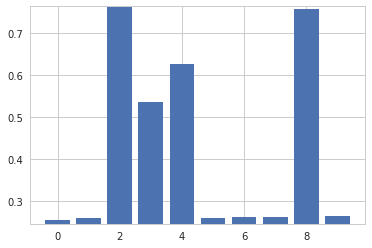

0.424825463763477


In [10]:
from sklearn.neural_network import MLPClassifier

X = new_df[feature_columns]
y = new_df["group_duration"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='relu', # type of non-linearity, every layer
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size= 'auto', # min of 200, num_samples
                    learning_rate='constant', # adapt learning? only for sgd
                    learning_rate_init=0.1, # only SGD
                    power_t=0.0,    # only SGD with inverse scaling of learning rate
                    max_iter=75, # stopping criteria
                    shuffle=True, 
                    random_state=1, 
                    tol=0, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=False, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.0, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer


cv = KFold(n_splits=10)
# select evaluation criteria
my_scorer = make_scorer(precision_score, average="macro")
# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf, X=X, y=y, cv=cv, scoring=my_scorer)

plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])
plt.show()

avg_score = np.mean(per_fold_eval_criteria)
print(avg_score)
